
#PREDICT AMOUNT OF TAXI

### MULTI-MODEL TRAINING AND COMPARISON FOR TAXI FARE PREDICTION

1. IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

2. LOAD DATA

In [2]:
df = pd.read_csv("TaxiFare.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (50000, 8)


,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


3. DATA CLEANING

In [3]:
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing fare (amount)
df = df.dropna(subset=['amount'])

# Keep only reasonable fares
df = df[(df['amount'] > 0) & (df['amount'] < 500)]

# Convert pickup datetime
df['date_time_of_pickup'] = pd.to_datetime(df['date_time_of_pickup'], errors='coerce')
df = df.dropna(subset=['date_time_of_pickup'])


Missing values per column:
unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64


4. FEATURE ENGINEERING

In [4]:
# Extract datetime features
df['year'] = df['date_time_of_pickup'].dt.year
df['month'] = df['date_time_of_pickup'].dt.month
df['day'] = df['date_time_of_pickup'].dt.day
df['hour'] = df['date_time_of_pickup'].dt.hour
df['weekday'] = df['date_time_of_pickup'].dt.weekday

# Drop unused columns
df = df.drop(columns=['unique_id', 'date_time_of_pickup'])

# Define feature matrix and target
X = df.drop(columns=['amount'])
y = df['amount']

5. SPLIT DATA

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

6. MODEL TRAINING & EVALUATION

In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = sqrt(mean_squared_error(y_test, preds))  # Manual RMSE
    r2 = r2_score(y_test, preds)
    results.append([name, mae, rmse, r2])
    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2_Score"])
print("\nModel Comparison:\n", results_df)


Linear Regression Performance:
MAE: 6.03 | RMSE: 9.75 | R²: 0.02

Decision Tree Performance:
MAE: 3.06 | RMSE: 6.36 | R²: 0.58

Random Forest Performance:
MAE: 2.13 | RMSE: 4.47 | R²: 0.79

Gradient Boosting Performance:
MAE: 2.95 | RMSE: 4.93 | R²: 0.75

XGBoost Performance:
MAE: 2.14 | RMSE: 4.75 | R²: 0.77

Model Comparison:
                Model       MAE      RMSE  R2_Score
0  Linear Regression  6.031416  9.747621  0.020704
1      Decision Tree  3.056516  6.356494  0.583560
2      Random Forest  2.130095  4.473321  0.793758
3  Gradient Boosting  2.951006  4.930731  0.749424
4            XGBoost  2.140223  4.754320  0.767033


7. HYPERPARAMETER TUNING (Best Model: Random Forest)

In [7]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                       cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_model = grid_rf.best_estimator_
print("\nBest Random Forest Params:", grid_rf.best_params_)

# Evaluate best model
best_preds = best_model.predict(X_test)
best_rmse = sqrt(mean_squared_error(y_test, best_preds))
best_r2 = r2_score(y_test, best_preds)
print(f"\nBest Random Forest Performance:\nRMSE: {best_rmse:.2f} | R²: {best_r2:.2f}")


Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Best Random Forest Performance:
RMSE: 4.46 | R²: 0.80


8. VISUALIZATION

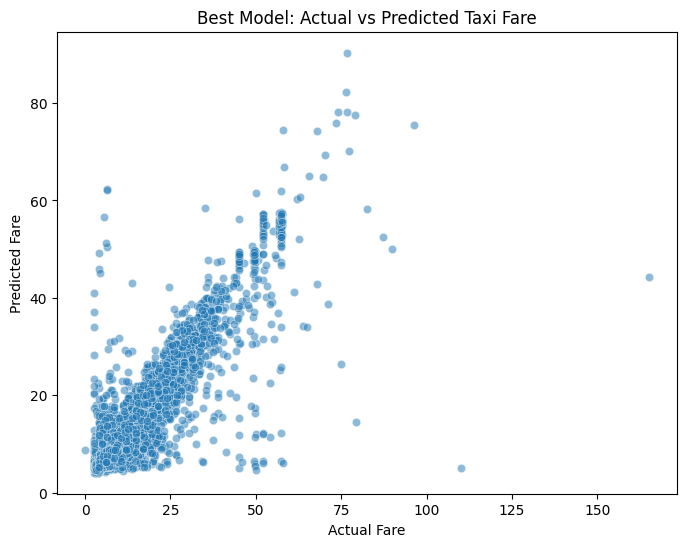

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=best_preds, alpha=0.5)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Best Model: Actual vs Predicted Taxi Fare")
plt.show()


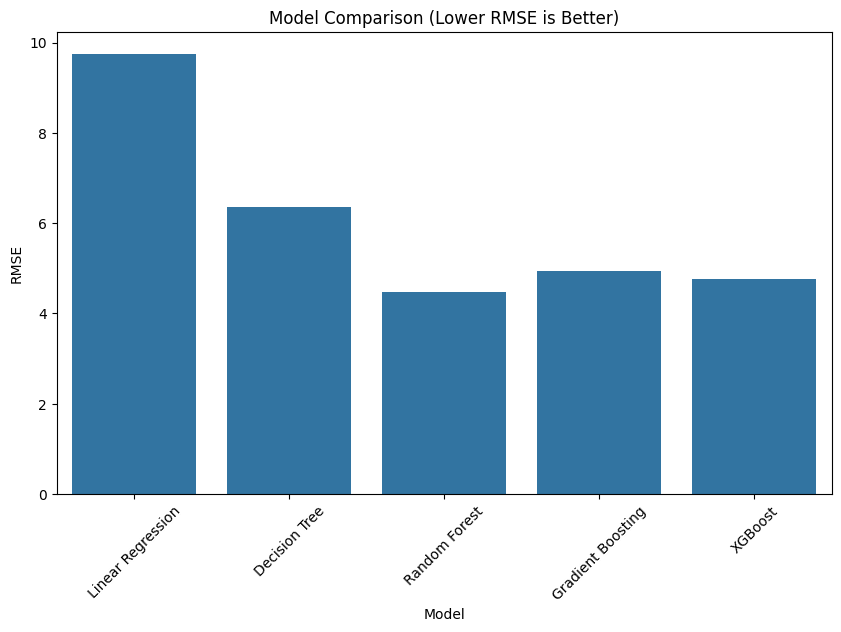

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.title("Model Comparison (Lower RMSE is Better)")
plt.xticks(rotation=45)
plt.show()

9. PREDICTION FUNCTION

In [9]:
def predict_fare(features_dict):
    """
    Predict taxi fare given trip details.

    features_dict: dictionary with keys matching model features
    """
    df_input = pd.DataFrame([features_dict])
    df_input_scaled = scaler.transform(df_input)
    fare_pred = best_model.predict(df_input_scaled)
    return round(fare_pred[0], 2)


# Example Prediction
example = {
    'longitude_of_pickup': -73.98,
    'latitude_of_pickup': 40.75,
    'longitude_of_dropoff': -73.99,
    'latitude_of_dropoff': 40.77,
    'no_of_passenger': 1,
    'year': 2025,
    'month': 9,
    'day': 3,
    'hour': 10,
    'weekday': 2
}

predicted_fare = predict_fare(example)
print(f"Predicted Taxi Fare: ${predicted_fare}")

Predicted Taxi Fare: $11.43
